In [105]:
import sys
import argparse
import torch
from torchvision import models
import torch.backends.cudnn as cudnn
from data_aug.contrastive_learning_dataset import ContrastiveLearningDataset
from models.resnet_simclr import ResNetSimCLR
import models.resnet_wider as res
from simclr import SimCLR
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch.nn as nn





In [16]:
args ={
"data" : "./datasets",
"dataset_name" : "cifar10",
"n_views" : 2,
"batch_size" : 256,
"workers" : 12,
"out_dim" : 128,
"arch" : "resnet18",
"weight_decay":1e-4,
"lr":0.0003,
"device":torch.device('cpu'),
"fp16_precision":False,
"temperature":0.07,
"epochs":1,
"disable_cuda":True
}

In [79]:
rasnet_18_ckp_path = 'C:/Users/Pietro/Documents/DELFT/courses/DL/DL_reprod/checkpoints/checkpoint_0050.pth.tar'
resnet_50_1x_ckp_path = 'C:/Users/Pietro/Documents/DELFT/courses/DL/DL_reprod/checkpoints/resnet_50_1x.pth'
resnet_50_4x_ckp_path = 'C:/Users/Pietro/Documents/DELFT/courses/DL/DL_reprod/checkpoints/resnet_50_4x.pth'
resnet_50_fine_tuned = 'C:/Users/Pietro/Documents/DELFT/courses/DL/DL_reprod/checkpoints/checkpoint_0050_FT.pth.tar'

In [80]:
dataset = ContrastiveLearningDataset(args["data"])
train_dataset = dataset.get_dataset(args["dataset_name"], args["n_views"])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True,num_workers=args["workers"], pin_memory=True, drop_last=True)

Files already downloaded and verified


In [111]:
resnet18 = ResNetSimCLR(base_model=args["arch"], out_dim=args["out_dim"]) 
resnet50x4 = res.resnet50x4()
resnet50x1 = res.resnet50x1()
resnet50x1_FT = res.resnet50x1()


In [113]:
sd_R18 = torch.load(rasnet_18_ckp_path, map_location='cpu')
print(sd_R18.keys())
resnet18.load_state_dict(sd_R18['state_dict'])
optimizer_R18 = torch.optim.Adam(resnet18.parameters(), args["lr"], weight_decay=args["weight_decay"])
scheduler_R18 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_R18, T_max=len(train_loader), eta_min=0,last_epoch=-1)
##
sd_R50x4 = torch.load(resnet_50_4x_ckp_path, map_location='cpu')
resnet50x4.load_state_dict(sd_R50x4['state_dict'])
optimizer_R50x4 = torch.optim.Adam(resnet50x4.parameters(), args["lr"], weight_decay=args["weight_decay"])
scheduler_R50x4 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_R50x4, T_max=len(train_loader), eta_min=0,last_epoch=-1)
##
sd_R50x1 = torch.load(resnet_50_1x_ckp_path, map_location='cpu')
print(sd_R50x1.keys())
resnet50x1.load_state_dict(sd_R50x1['state_dict'])
optimizer_R50x1 = torch.optim.Adam(resnet50x1.parameters(), args["lr"], weight_decay=args["weight_decay"])
scheduler_R50x1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_R50x1, T_max=len(train_loader), eta_min=0,last_epoch=-1)
##

sd_R50x1_FT = torch.load(resnet_50_fine_tuned, map_location='cpu')
resnet50x1_FT.fc = nn.Sequential(resnet50x1_FT.fc,nn.ReLU(),nn.Linear(1000,128))

print(sd_R50x1_FT.keys())
resnet50x1_FT.load_state_dict(sd_R50x1_FT['state_dict'])
optimizer_R50x1_FT = torch.optim.Adam(resnet50x1.parameters(), args["lr"], weight_decay=args["weight_decay"])
scheduler_R50x1_FT = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_R50x1_FT, T_max=len(train_loader), eta_min=0,last_epoch=-1)

dict_keys(['epoch', 'arch', 'state_dict', 'optimizer'])
dict_keys(['state_dict'])
dict_keys(['epoch', 'arch', 'state_dict', 'optimizer'])


In [114]:
features = []
with torch.cuda.device(-1):
        simclr = SimCLR(model=resnet18, optimizer=optimizer_R18, scheduler=scheduler_R18, args=args)
        features.append(simclr.train(train_loader))
        ##
        simclr = SimCLR(model=resnet50x1, optimizer=optimizer_R50x4, scheduler=scheduler_R50x4, args=args)
        features.append(simclr.train(train_loader))
        ##
        simclr = SimCLR(model=resnet50x4, optimizer=optimizer_R50x1, scheduler=scheduler_R50x1, args=args)
        features.append(simclr.train(train_loader))
        ##
        simclr = SimCLR(model=resnet50x1_FT, optimizer=optimizer_R50x1_FT, scheduler=scheduler_R50x1_FT, args=args)
        features.append(simclr.train(train_loader))

  3%|██                                                                                | 5/195 [01:05<41:28, 13.10s/it]


In [115]:
colors = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']
pca = PCA(n_components=3)
PCAs = []
infolosses = []

In [116]:
for model_features in features:
    pca = PCA(n_components=3)
    temp_pca = pca.fit_transform(model_features)
    PCAs.append(temp_pca)
    infolosses.append(pca.explained_variance_ratio_)

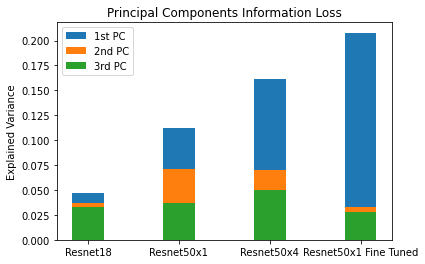

In [117]:
labels = ['Resnet18', 'Resnet50x1', 'Resnet50x4', 'Resnet50x1 Fine Tuned']
width = 0.35

pca1 = [x[0] for x in  infolosses]
pca2 = [x[1] for x in  infolosses]
pca3 = [x[2] for x in  infolosses]

infoloss = [1-sum(pca1),1-sum(pca2),1-sum(pca3)]


fig, ax = plt.subplots()
#ax.bar(labels, infoloss, width, label='Information loss')
ax.bar(labels, pca1, width,label='1st PC')
ax.bar(labels, pca2, width, label='2nd PC')
ax.bar(labels, pca3, width, label='3rd PC')


ax.set_ylabel('Explained Variance')
ax.set_title('Principal Components Information Loss')
ax.legend()

plt.show()
fig.savefig('temp.png', dpi=fig.dpi)

In [118]:
pca1

[0.046787452, 0.111874685, 0.16140918, 0.2078158]

In [119]:
pca2

[0.037336126, 0.07056011, 0.069925316, 0.03307657]

In [120]:
pca3

[0.03313176, 0.0370309, 0.05036166, 0.02817499]